In [1]:
import mido
import midi_io

import numpy as np

import matplotlib.pyplot as plt

In [2]:
from contour import get_contours, sort_contours
from oscilloscope import OscilloscopeDrawer

In [3]:
from video_io import read_frames

# Read Video

In [9]:
frames, fps = read_frames('Images/mauzy_dance_trim.mp4')

## Video Pre-Processing
Do some pre-processing on the video (e.g. cropping) if deemed necessary.

In [10]:
# Crop
for i, frame in enumerate(frames):
    frames[i] = frame[70:,145:465] #[50:,130:480]

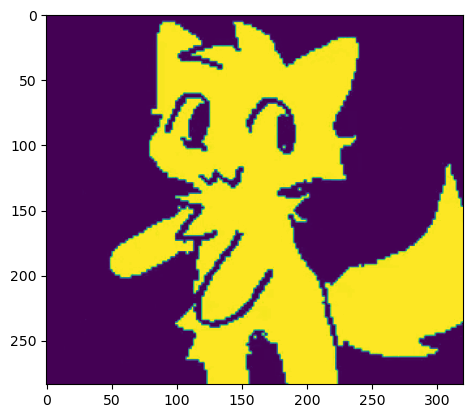

In [11]:
plt.imshow(frames[200])

## Test Contour Detection
Select a pixel value threshold for contour detection.

In [12]:
threshold = 150

In [13]:
contours = get_contours(frames[-1], threshold=threshold)

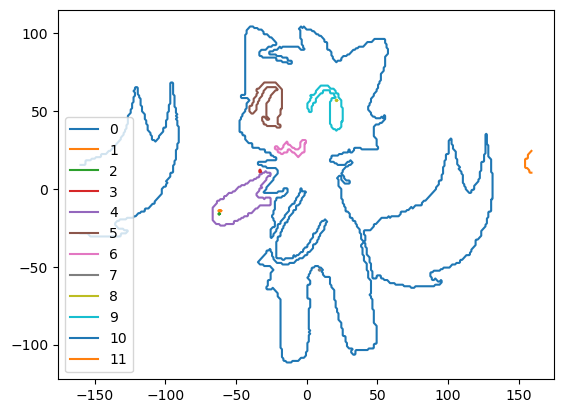

In [14]:
for i, contour in enumerate(contours):
    plt.plot([c[0] for c in contour], [c[1] for c in contour], label=i)
plt.legend()

# Read Midi File

In [15]:
mid = mido.MidiFile('Samples/eek_reworked.mid')

In [16]:
tempo = midi_io.get_tempo(mid.tracks[-1])
time_sig = midi_io.get_time_sig(mid.tracks[-1])

bpm = mido.tempo2bpm(tempo, time_sig)

In [17]:
durations_1, freqs_1 = midi_io.track_to_freqs(mid.tracks[0], bpm, mid.ticks_per_beat, ignore_rests=True)
durations_2, freqs_2 = midi_io.track_to_freqs(mid.tracks[1], bpm, mid.ticks_per_beat, ignore_rests=True)

C:\Users\dennis\Documents\Oscilloscope\midi_io.py:32: UserWarning: Two or more notes are played at the same time on channel 0. Only the sequentially first note will be played.
  warnings.warn(f"Two or more notes are played at the same time on channel {msg.channel}. Only the sequentially first note will be played.")


In [18]:
# I'm taking the frequencies for this song down a few measures because it is quite high
freqs_1 = np.array(freqs_1)/2
freqs_2 = np.array(freqs_2)/2

# Oscilloscope Drawing

In [19]:
# Oscilloscope parameters
rate = 500000 # Samples per second
data_type = np.int16

save_path = 'Samples'

In [20]:
drawer = OscilloscopeDrawer(frames[0].shape, rate=rate, data_type=data_type, save_path=save_path)

## Create Drawing from Video

In [21]:
x, y = np.array([]), np.array([])

frame, time = 0, 0
contours, _ = sort_contours(get_contours(frames[0]))
for duration, freq in zip(durations_1, freqs_1):
    if freq == 0:
        x = np.append(x, np.zeros(int(duration*rate)))
        y = np.append(y, np.zeros(int(duration*rate)))
        
        time += duration
        frame = int(time*fps)
        contours, _ = sort_contours(get_contours(frames[frame], threshold=150))
        
        continue
    
    # Create oscilloscope drawing
    x_frame, y_frame = np.array([]), np.array([])
    num_frames = int(duration*rate)
    while x_frame.size < num_frames:
        if len(contours) == 0:
            time_to_next_frame = (frame+1)/fps - time
            samples_to_next_frame = int(time_to_next_frame * rate)+1
            
            x_frame = np.append(x_frame, np.zeros(samples_to_next_frame))
            y_frame = np.append(x_frame, np.zeros(samples_to_next_frame))
            
            time += samples_to_next_frame/rate
        
        current_frame = int(time*fps)
        if current_frame > frame and current_frame < len(frames):
            frame = current_frame
            contours, _ = sort_contours(get_contours(frames[frame], threshold=150))
            print(f"Frame {frame}")
    
        x_drawing, y_drawing = drawer.play_drawing(freq, contours)
        
        x_frame = np.append(x_frame, x_drawing)
        y_frame = np.append(y_frame, y_drawing)
        
        time += x_drawing.size / rate
    
    x = np.append(x, x_frame[:num_frames])
    y = np.append(y, y_frame[:num_frames])
    
    time = x.size / rate

Frame 112
Frame 113
Frame 114
Frame 115
Frame 116
Frame 117
Frame 118
Frame 119
Frame 120
Frame 121
Frame 122
Frame 123
Frame 124
Frame 125
Frame 126
Frame 127
Frame 128
Frame 129
Frame 130
Frame 131
Frame 132
Frame 133
Frame 134
Frame 135
Frame 136
Frame 137
Frame 138
Frame 139
Frame 140
Frame 141
Frame 142
Frame 143
Frame 144
Frame 145
Frame 146
Frame 147
Frame 148
Frame 149
Frame 150
Frame 151
Frame 152
Frame 153
Frame 154
Frame 155
Frame 156
Frame 157
Frame 158
Frame 159
Frame 160
Frame 161
Frame 162
Frame 163
Frame 164
Frame 165
Frame 166
Frame 167
Frame 168
Frame 169
Frame 170
Frame 171
Frame 172
Frame 173
Frame 174
Frame 175
Frame 176
Frame 177
Frame 178
Frame 179
Frame 180
Frame 181
Frame 182
Frame 183
Frame 184
Frame 185
Frame 186
Frame 187
Frame 188
Frame 189
Frame 190
Frame 191
Frame 192
Frame 193
Frame 194
Frame 195
Frame 196
Frame 197
Frame 198
Frame 199
Frame 200
Frame 201
Frame 202
Frame 203
Frame 204
Frame 205
Frame 206
Frame 207
Frame 208
Frame 209
Frame 210
Frame 211


## Create Square Wave

In [22]:
square_wave = drawer.play_square_wave(durations_2, freqs_2)

## The Final Oscilloscope Drawing

In [23]:
length = max(x.size, square_wave.size)

In [24]:
# Pad arrays with 0s at the end so that they are all of equal length
x_pad = np.pad(x, (0,length-x.size))
y_pad = np.pad(y, (0,length-y.size))
square_wave_pad = np.pad(square_wave, (0,length-square_wave.size))

In [25]:
drawer.write_wav(x_pad/2+square_wave_pad, y_pad/2+square_wave_pad, 'midi_video')